In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 1. Data Preprocessing and Feature Engineering

## Clean and Prepare

In [2]:
df = pd.read_csv('../data/ads_all_cleaned.csv')

### Missing Values

One missing value in title which we will ignore

In [3]:
df.isnull().sum()

id                  0
num_of_pic          0
price               0
brand               0
model               0
title               1
year                0
km                  0
steering_side       0
region_specs        0
location            0
location_cleaned    0
dtype: int64

### Outliers

I will choose to keep outliers.

## Feature Engineering

Below is the wordcloud that was generated in the data analysis phase in the ads_all_after_cleaning.html report

Some of the more common words which could be useful are **warranty**, **accident** (to determine ads where there is specific mention that the car is accident free), **service** (to indicate a full service history) 

![wordcloud](../data/title-column-wordcloud.png)

In [4]:
# Feature Engineering
df['warranty'] = df['title'].apply(lambda x: True if 'warranty' in str(x).lower() else False)
df['service_hist'] = df['title'].apply(lambda x: True if 'service' in str(x).lower() else False)
df['no_accident'] = df['title'].apply(lambda x: True if 'accident' in str(x).lower() else False)

luxury_brands = ['mercedez-benz','lexus','bmw','audi']
df['luxury'] = df['brand'].apply(lambda x: 1 if x.lower() in luxury_brands else 0)

df['age'] = 2024 - df['year']

df.drop(['id','title','year','location'], axis=1, inplace=True)


## Data Preprocessing

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Define feature columns
categorical_features = ['brand','model','steering_side','region_specs','location_cleaned']
numerical_features = ['km','age','num_of_pic']
binary_features = ['warranty', 'service_hist', 'no_accident','luxury']

# Preprocessing pipelines
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
    # ('scaler', StandardScaler())
])

binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=False))
])

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('bin', binary_transformer, binary_features)
    ])

In [6]:
X = df.drop('price', axis=1)
y = df['price']

In [7]:
X

,num_of_pic,brand,model,km,steering_side,region_specs,location_cleaned,warranty,service_hist,no_accident,luxury,age
0,17,Ford,F-Series Pickup,107000,Left Hand,GCC Specs,Dubai,False,True,False,0,6
1,18,Ford,Mustang,2000,Left Hand,American Specs,Sharjah,True,False,False,0,3
2,19,Ford,Edge,79000,Left Hand,GCC Specs,Dubai,False,True,False,0,8
3,19,Ford,Mustang,55000,Left Hand,GCC Specs,Dubai,True,True,False,0,4
4,19,Ford,Mustang,29000,Left Hand,GCC Specs,Dubai,True,True,False,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
20867,20,Volkswagen,Passat,107624,Left Hand,GCC Specs,Dubai,False,True,False,0,10
20868,17,Volkswagen,Tiguan,0,Left Hand,Chinese Specs,Dubai,False,False,False,0,1
20869,17,Volkswagen,Transporter,0,Left Hand,GCC Specs,Dubai,False,False,False,0,5
20870,17,Volkswagen,Touareg,54300,Left Hand,GCC Specs,Dubai,False,False,False,0,3


In [8]:
y

0        159000
1        276000
2         62500
3        169000
4        209000
          ...  
20867     26000
20868    110000
20869     79000
20870    185000
20871     57000
Name: price, Length: 20872, dtype: int64

In [9]:
# train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=0)

# 2. Model Training

In [10]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import lightgbm as lgb
from datetime import datetime

# Define the models
models = {
    'linear_regression': LinearRegression(),
    'svm': LinearSVR(max_iter=1000),
    'random_forest': RandomForestRegressor(),
    'gradient_boosted_rf': HistGradientBoostingRegressor(),
    'xgboost': xgb.XGBRegressor(),
    'lightgbm': lgb.LGBMRegressor()
}

def train_models(models):
    # Dictionary to hold the results
    results = {
        'model': [],
        'MAE': [],
        'R2': [],
        'training_time': []
    }

    cv_scores = {}

    # Iterate over the models
    for model_name, model in models.items():
        # Create pipeline with preprocessor and model
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        train_start = datetime.now()
        pipeline.fit(X_train, y_train)
        train_stop = datetime.now()
        train_time = train_stop - train_start

        y_pred = pipeline.predict(X_test)

        # Perform k-fold cross-validation
        cv_score = cross_val_score(pipeline, X, y, cv=10, scoring='neg_mean_absolute_error')

        cv_scores[model_name] = -cv_score
        
        # Calculate the mean MAE score across folds
        mean_mae = -cv_score.mean()
        
        # Collect the results
        results['model'].append(model_name)
        results['MAE'].append(mean_mae)
        results['R2'].append(r2_score(y_test, y_pred))
        results['training_time'].append(train_time.total_seconds())  # Convert to seconds for easier readability

    return results, cv_scores
    
results, cv_scores = train_models(models)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 497
[LightGBM] [Info] Number of data points in the train set: 4174, number of used features: 95
[LightGBM] [Info] Start training from score 152932.704121
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 18784, number of used features: 205
[LightGBM] [Info] Start training from score 159069.433667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

# 3. Model Evaluation and Selection

In [14]:
# Convert the results to a DataFrame
results_df = pd.DataFrame(results).set_index('model')

# Display the DataFrame
results_df

,MAE,R2,training_time
model,,,
linear_regression,84048.626664,-8.931277e+07,0.164168
svm,167323.751657,-7.892748e-01,0.301040
random_forest,45722.455395,3.164514e-01,12.132669
gradient_boosted_rf,56923.942802,2.844169e-01,6.322092
xgboost,47262.166245,3.432632e-01,0.393491
lightgbm,55767.041593,2.817230e-01,0.247080


### Model Training Outliers Removed

In [15]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

In [16]:
df_outliers_removed = df[(df['price'] > lower_limit) & (df['price'] < upper_limit)]

X = df_outliers_removed.drop('price', axis=1)
y = df_outliers_removed['price']

# train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=0)

# Training model
results, cv_scores = train_models(models)

# Convert the results to a DataFrame
results_df = pd.DataFrame(results).set_index('model')

# Display the DataFrame
results_df

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 483
[LightGBM] [Info] Number of data points in the train set: 3865, number of used features: 91
[LightGBM] [Info] Start training from score 99724.522122
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 707
[LightGBM] [Info] Number of data points in the train set: 17392, number of used features: 194
[LightGBM] [Info] Start training from score 105451.881900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is no

,MAE,R2,training_time
model,,,
linear_regression,32327.963591,0.674268,0.123234
svm,118633.178776,-0.709983,0.241887
random_forest,22315.301871,0.809851,8.562571
gradient_boosted_rf,23659.635654,0.772424,4.459329
xgboost,22709.247833,0.842149,0.304321
lightgbm,23469.513783,0.773406,0.201911


It seems that outliers do significantly impact the models. The effect on our tree based models is that the error has halved with very significant improvements to the linear regression model.

Random Forrest seams to give the best results in terms of MAE but I will choose to go with XGBoost seeing as it is the second most accurate model with the best fit to the data and low training time.

SVM definetly is a terrible fit so no point in moving forward with that.

<Axes: >

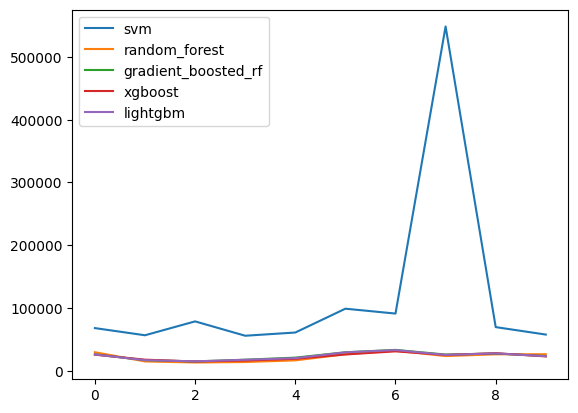

In [17]:
model_training = pd.DataFrame(cv_scores).iloc[:,1:]
model_training.plot(kind='line')

# 4. Model Tuning

**Selected Model:** XGBoost

**Choice of parameter to tune:** https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html#:~:text=Tune%20the%20XGBoost%20model%20with%20the%20following%20hyperparameters.,metrics%20are%3A%20alpha%2C%20min_child_weight%2C%20subsample%2C%20eta%2C%20and%20num_round.

In [18]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor())
])

param_grid = {
    'model__reg_alpha':[0.1,0.5,1,1.5,2],
    'model__min_child_weight':[0.1,0.5,1,3,6,9],
    'model__subsample':[0.05,0.1,0.15,0.2,0.3],
    'model__learning_rate':[0.01,0.1,0.3,0.5,0.8],
}

gs = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error'
)

gs.fit(X_train, y_train)

print("Best parameters: ", gs.best_params_)
print("Best score: ", gs.best_score_)

Best parameters:  {'model__learning_rate': 0.3, 'model__min_child_weight': 0.1, 'model__reg_alpha': 0.1, 'model__subsample': 0.3}
Best score:  -21816.760724295433


Tuning doesn't improve the model too sinificantly.

# ANNEX 1. Ensemble Model

Lets try building an ensemble model where we train the data for luxury and non-luxury cars separately and use each model to predict prices of cars for that section.